G05: Winkler, Jakober, Matzinger, Salzmann

In [1]:
import os
import glob
import string
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torchsummary import summary

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# %pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [3]:
srcdir = 'data/names'
languages = ["English", "French", "Italian", "German", "Spanish"]

In [4]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [5]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/Czech.txt
data/names/German.txt
data/names/Arabic.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/Spanish.txt
data/names/Greek.txt
data/names/Italian.txt
data/names/Portuguese.txt
data/names/Scottish.txt
data/names/Dutch.txt
data/names/Korean.txt
data/names/Polish.txt


In [6]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [7]:
names = load_data(srcdir, categories=languages)
names.head()

,name,lang
0,Abbing,German
1,Abel,German
2,Abeln,German
3,Abt,German
4,Achilles,German


In [8]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [9]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [10]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [ ]:
language_to_index = {country: index for index, country in enumerate(names.lang.unique())}
index_to_language = {index: country for index, country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length)
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with
    for k in range(0, maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### END YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]] = 1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [12]:
test_split = 0.2

### START YOUR CODE
names_shuffled = names.sample(frac=1, random_state=42)
n_test = int(len(names) * test_split)

train = names_shuffled.iloc[n_test:]
test = names_shuffled.iloc[:n_test]
### END YOUR CODE

In [13]:
print(train.shape)
print(test.shape)

(4541, 2)
(1135, 2)


In [35]:
### START YOUR CODE
X_train = train['name'].apply(lambda name: name_representation(name, maxlen))
Y_train = train['lang'].apply(lambda lang: lang_representation(lang, language_to_index))

# X_test = test['name'].apply(lambda name: name_representation(name, maxlen))
Y_test = test['lang'].apply(lambda lang: lang_representation(lang, language_to_index))
### END YOUR CODE

In [15]:
class NameDataset(torch.utils.data.Dataset):
    def __init__(self, df, char_index, language_to_index, maxlen):
        self.data = df.reset_index(drop=True)
        self.char_index = char_index
        self.language_to_index = language_to_index
        self.maxlen = maxlen

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name = self.data.loc[idx, 'name']
        lang = self.data.loc[idx, 'lang']

        name_vec = name_representation(name, self.maxlen)
        lang_idx = self.language_to_index[lang]

        return torch.from_numpy(np.array(name_vec)).float(), torch.tensor(lang_idx, dtype=torch.long)

In [16]:
Xy_train = NameDataset(train, char_index, language_to_index, maxlen)
Xy_test = NameDataset(test, char_index, language_to_index, maxlen)

Possibly, pack the data into a Dataset (e.g. when working with in PyTorch)

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [17]:
### START YOUR CODE
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_dim, 
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, h = self.rnn(x)
        return self.fc(h[-1])

### END YOUR CODE

In [ ]:
def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    """
    Trains and evaluates the model for n_epochs.
    """
    total_batches = n_epochs * len(train_loader)
    progress = tqdm(total=total_batches, desc="Training Progress", leave=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(n_epochs):
        train_loss = 0
        train_correct = 0
        train_total = 0
        y_preds, y_trues = [], []

        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, y_pred = torch.max(output, 1)
            train_correct += (y_pred == y_train).sum().item()
            train_total += y_train.size(0)

            progress.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        val_loss = 0
        val_correct = 0
        val_total = 0

        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                output = model(X_val)
                loss = criterion(output, y_val)

                val_loss += loss.item()
                _, y_pred = torch.max(output, 1)
                val_correct += (y_pred == y_val).sum().item()
                val_total += y_val.size(0)
        
        y_preds.append(y_pred.detach().cpu())
        y_trues.append(y_val.detach().cpu())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        progress.set_postfix({
            'Epoch': f'{epoch + 1}/{n_epochs}',
            'Train Loss': f'{avg_train_loss:.4f}',
            'Val Loss': f'{avg_val_loss:.4f}',
            'Train Acc': f'{train_acc:.4f}',
            'Val Acc': f'{val_acc:.4f}'
        })
    
    y_preds = torch.cat(y_preds, dim=0).numpy()
    y_trues = torch.cat(y_trues, dim=0).numpy()

    progress.close()
    return train_losses, val_losses, train_accs, val_accs, y_preds, y_trues

In [19]:
### START YOUR CODE
results_single_layer = {}

n_epochs = 50
batch_sizes = [64, 128, 256]
input_dim = len(char_index)
hidden_dims = [32, 64, 128]
output_dim = len(language_to_index)

for batch_size in batch_sizes:
    train_loader = DataLoader(Xy_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(Xy_test, batch_size=batch_size, shuffle=False)

    for hidden_dim in hidden_dims:
        model = RNN(input_dim, hidden_dim, output_dim).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, test_loader, optimizer, criterion, n_epochs)
        results_single_layer[f'{batch_size, hidden_dim}'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues
### END YOUR CODE

Training Progress: 100%|██████████| 900/900 [00:16<00:00, 54.96it/s, Epoch=50/50, Train Loss=0.7188, Val Loss=0.7807, Train Acc=0.7415, Val Acc=0.7154]


In [20]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc, y_preds, y_trues, title, split):
    
    fig, ax = plt.subplots(1, 3, figsize=(24,6))

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_xticks(range(0, n_epochs+1, 5))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_xticks(range(0, n_epochs+1, 5))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[2])

    if split:
        batch_size, hidden_dim  = title.strip('()').split(',')
        fig.suptitle(f'Batch size: {batch_size} | Hidden dim:{hidden_dim}')
    else:
        fig.suptitle(title)
    plt.show()

In [21]:
def stacked_plots(results, split=False):
    for key, item in results.items():
        plot_loss_curve(n_epochs, item[0], item[1], item[2], item[3], item[4], item[5], key, split)

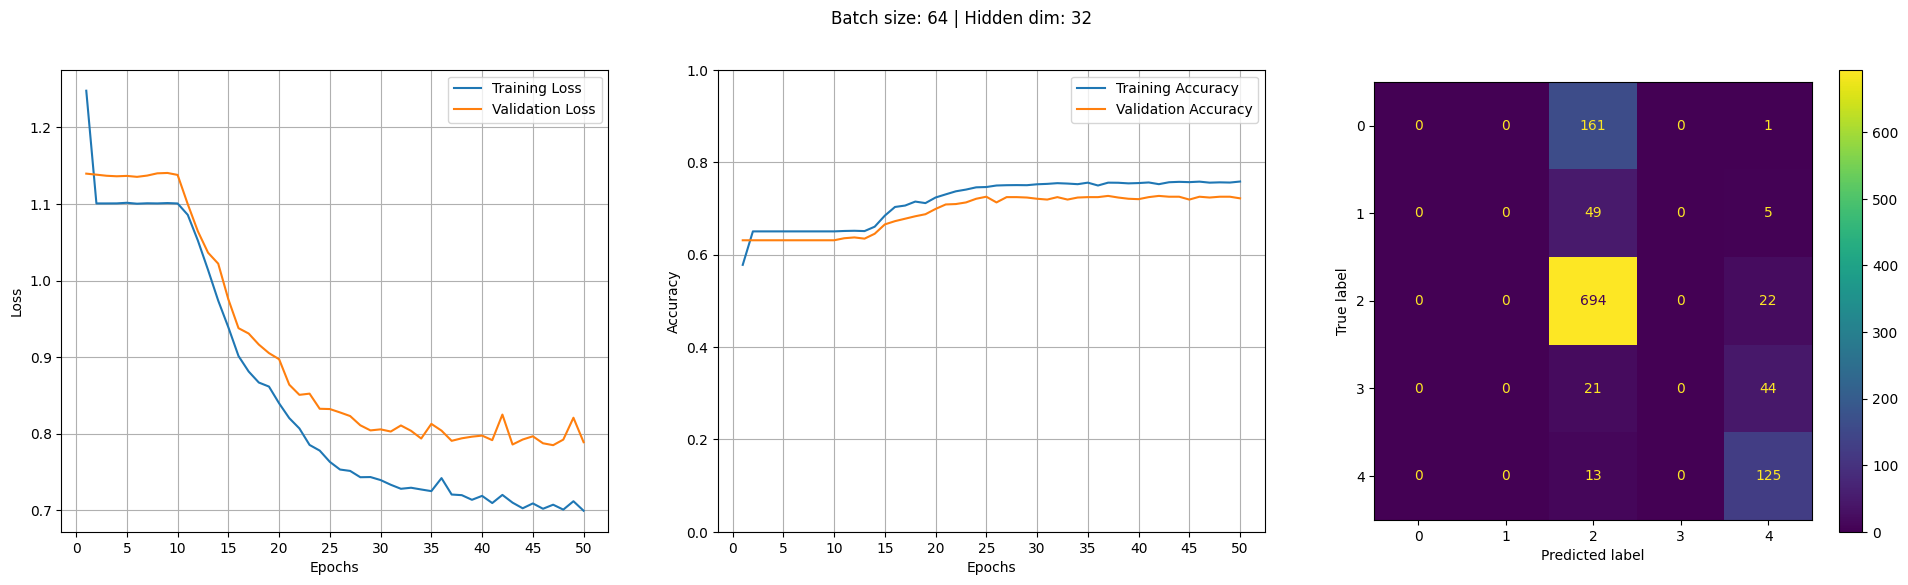

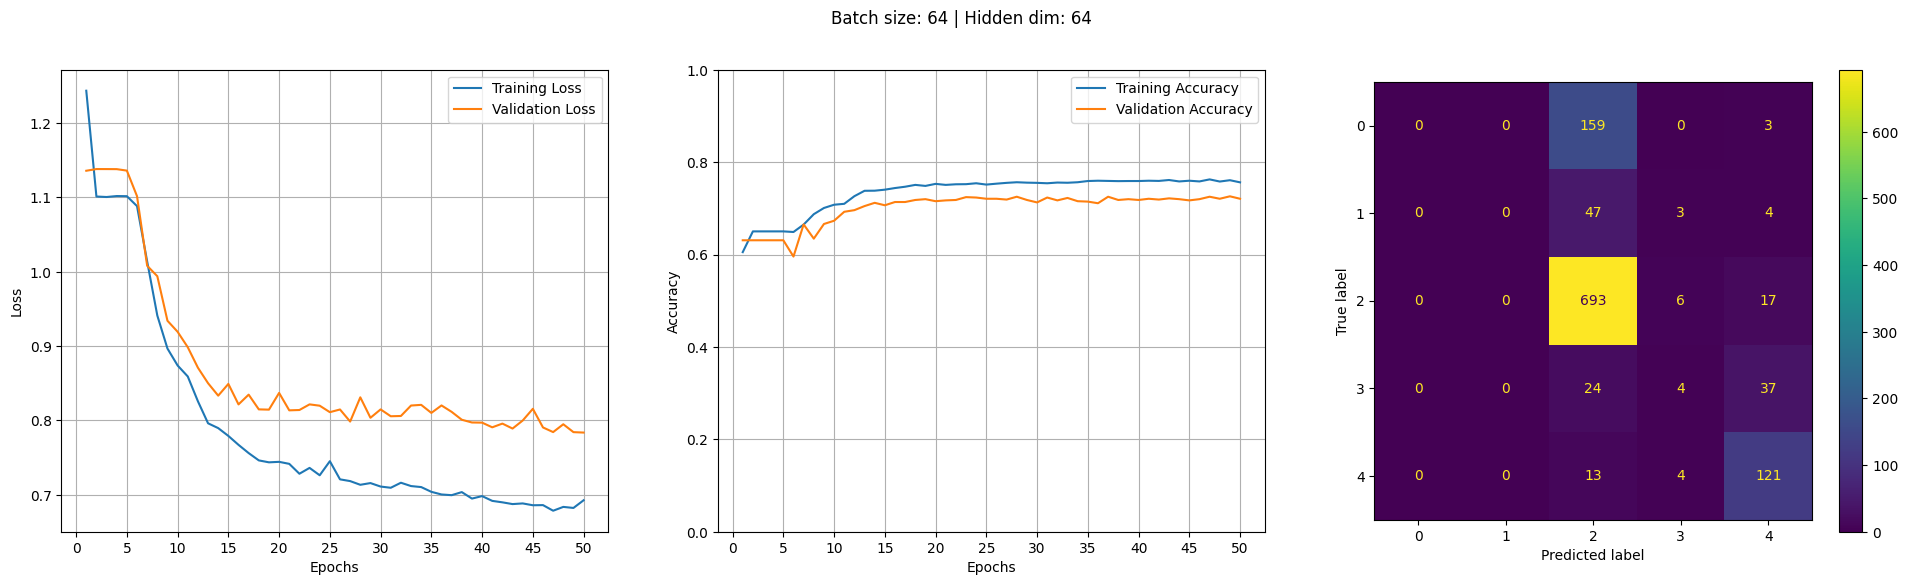

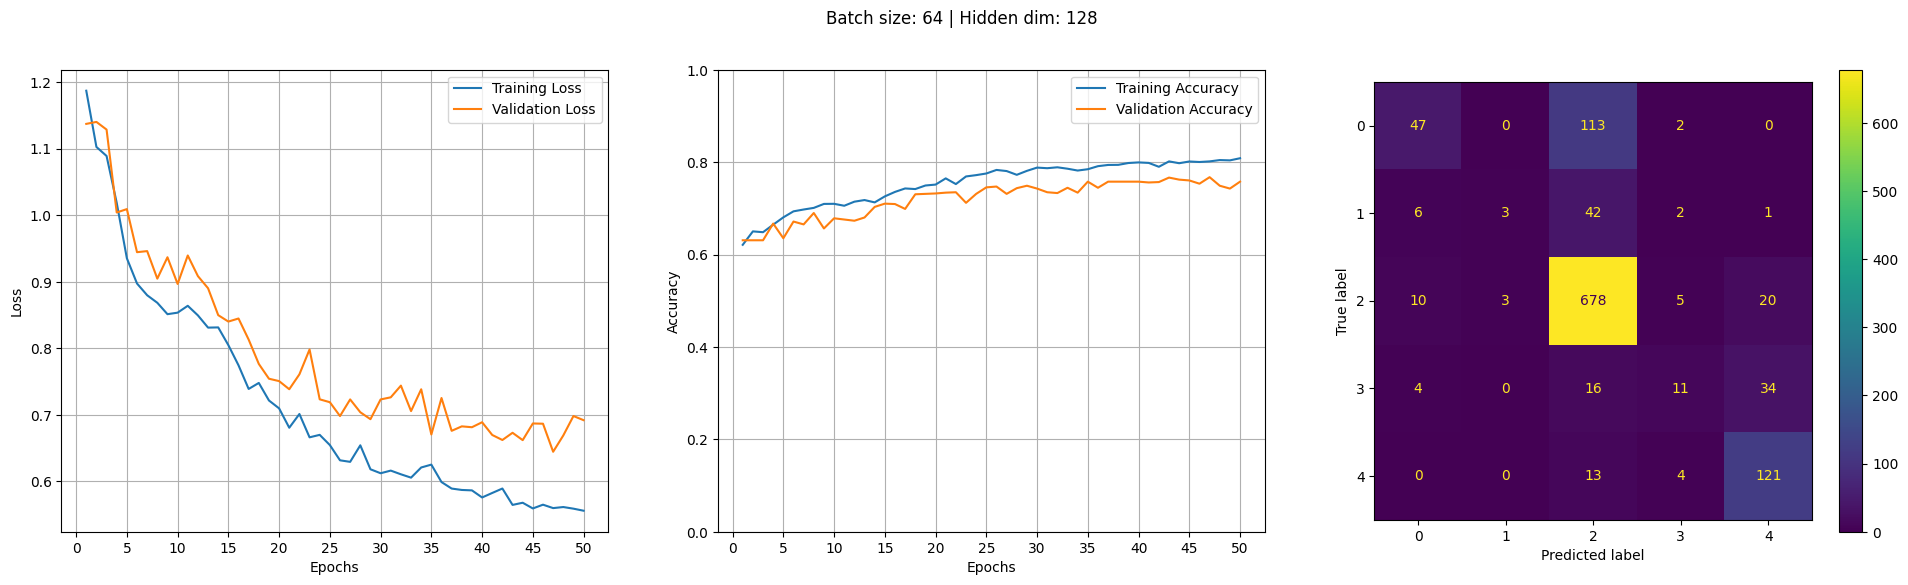

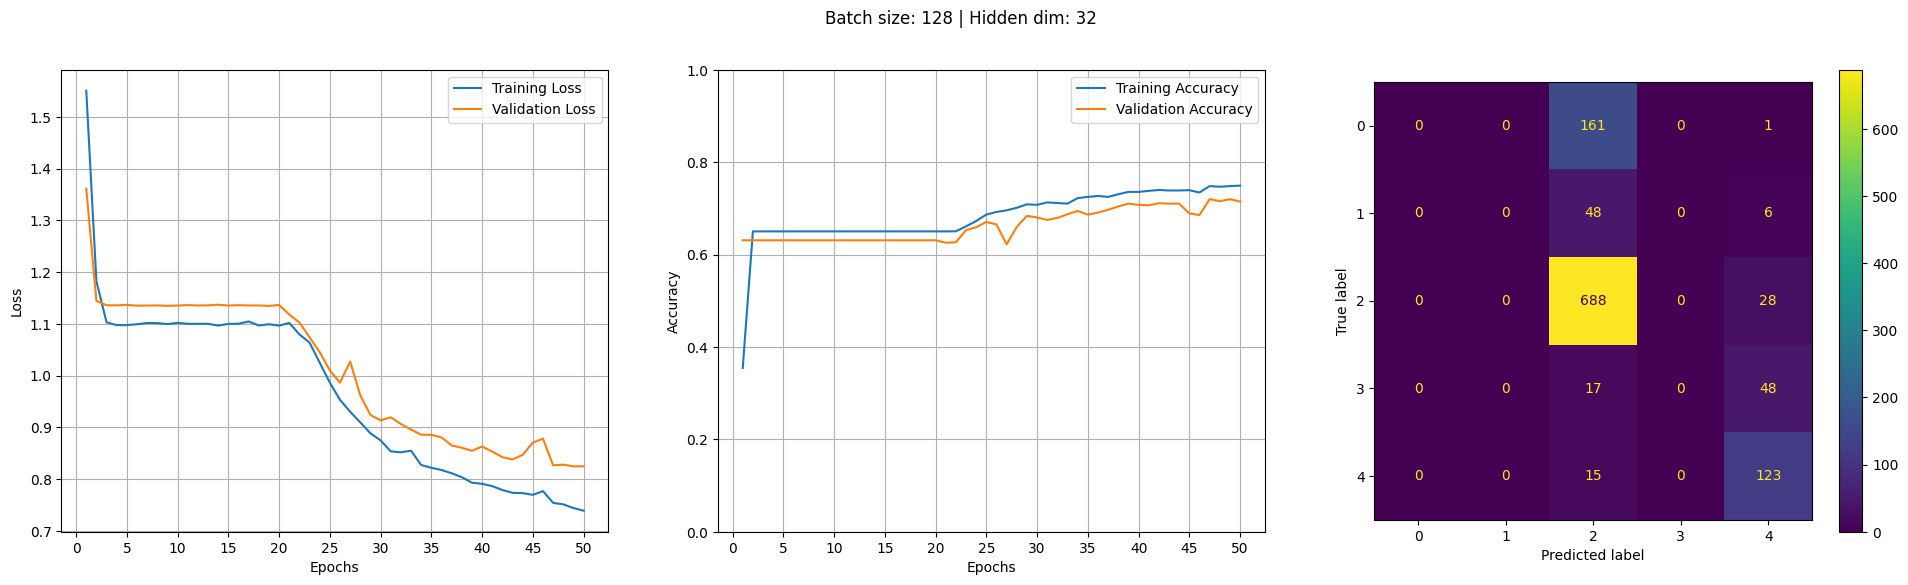

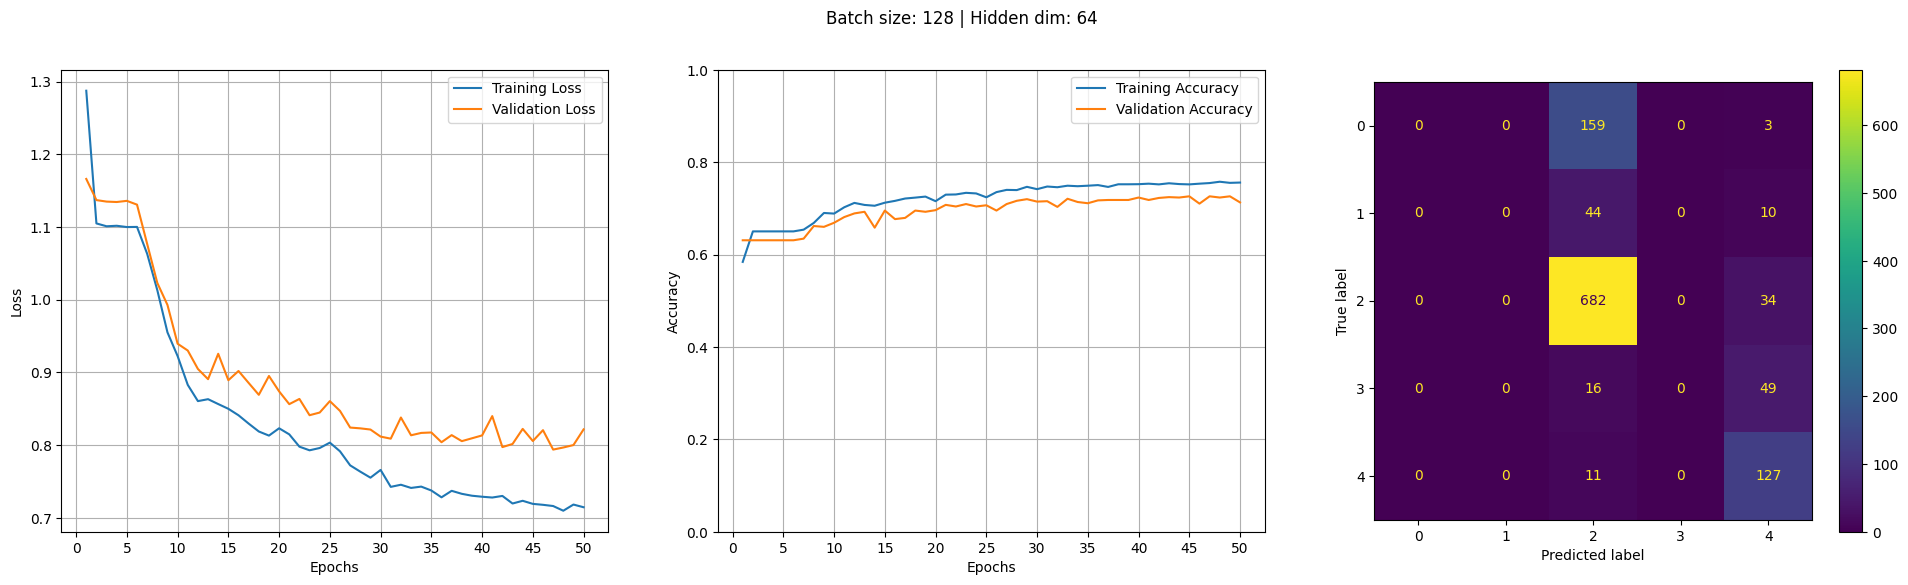

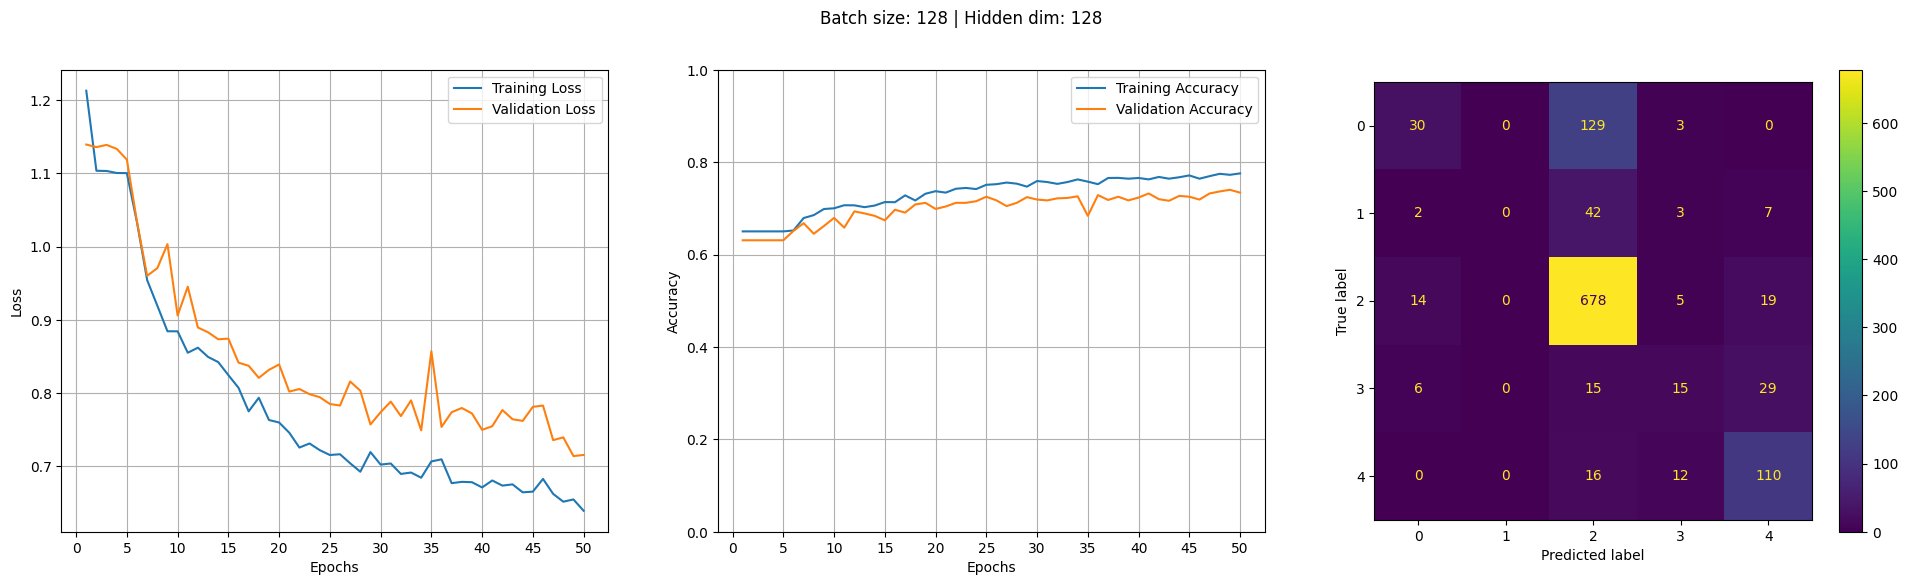

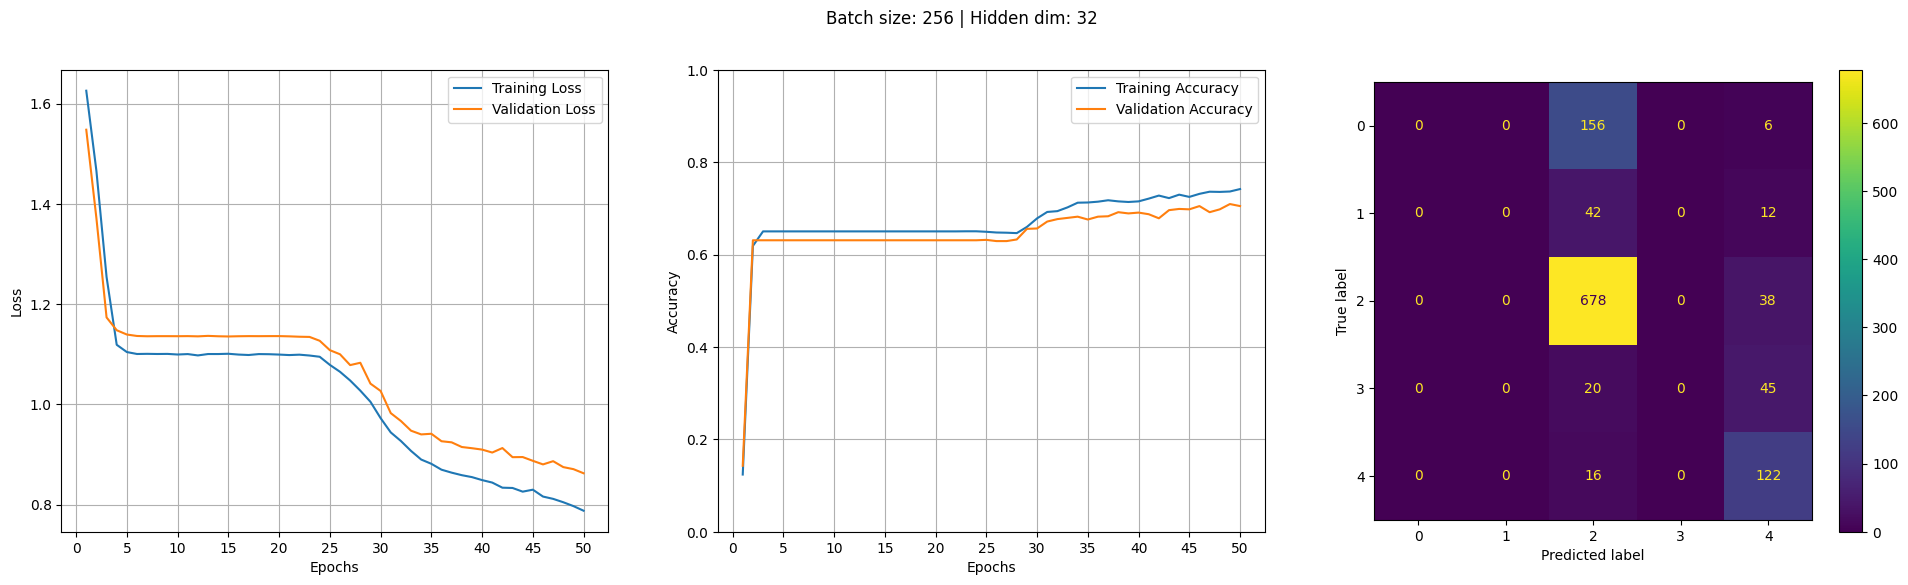

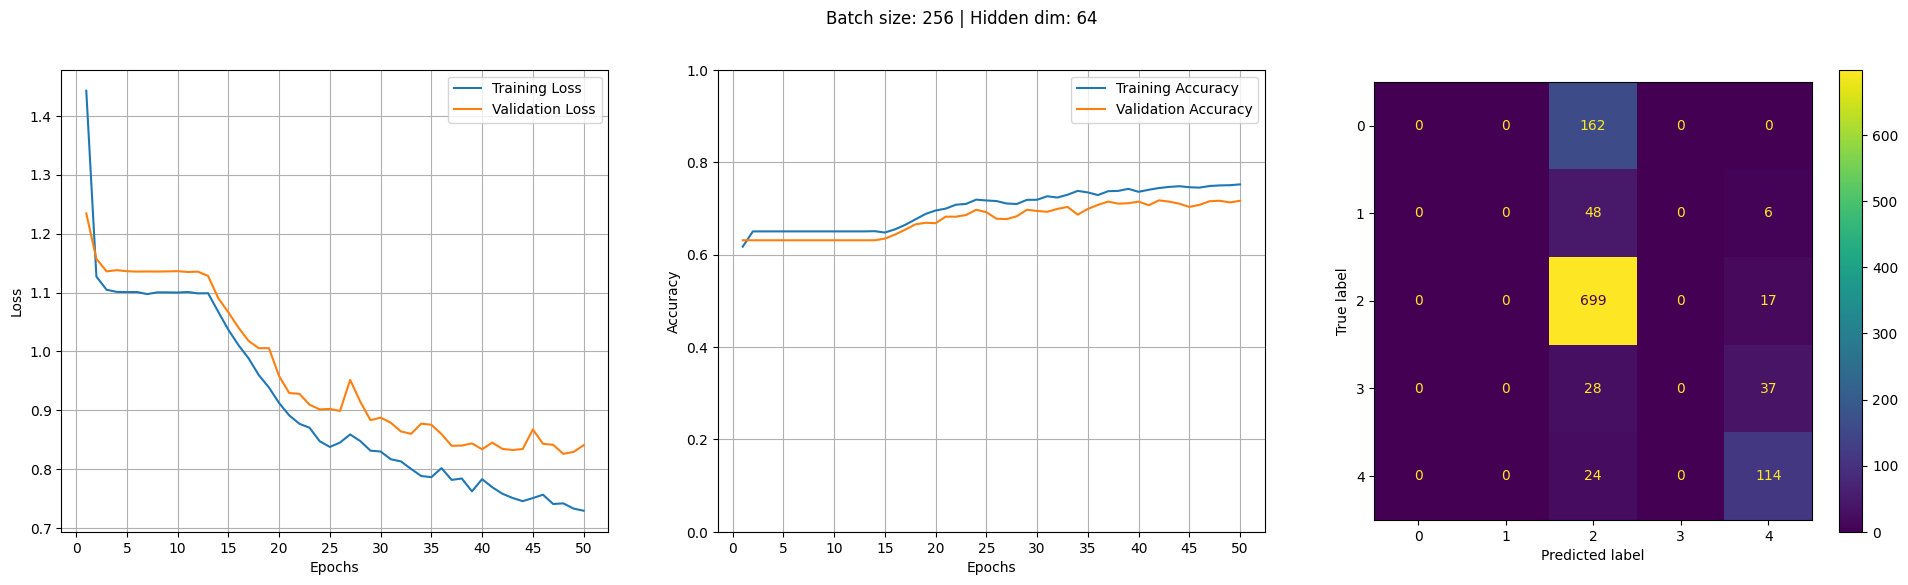

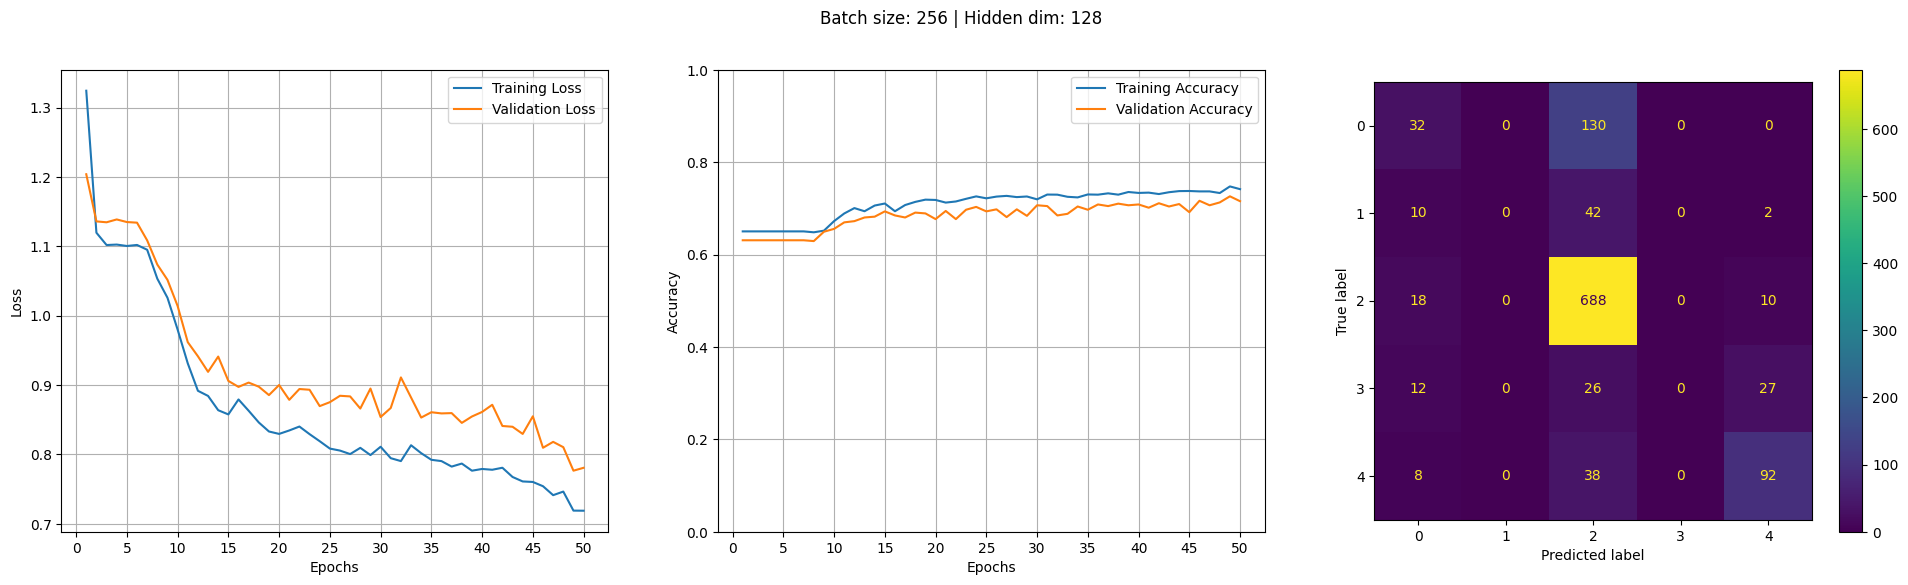

In [22]:
stacked_plots(results_single_layer, split=True)

#### Findings

Although the loss and accuracy curves suggest stable learning and relatively good performance across architectures, the confusion matrices show that the dataset is heavily biased towards label 2 (majority class).

### Implement Model with several SimpleRNN Layers

In [23]:
### START YOUR CODE
results_multi_layer = {}

batch_size = 128
hidden_dim = 64
n_layers = [2, 3, 4, 5]

train_loader = DataLoader(Xy_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Xy_test, batch_size=batch_size, shuffle=False)

for n_layer in n_layers:
    model = RNN(input_dim, hidden_dim, output_dim, n_layer).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, test_loader, optimizer, criterion, n_epochs)
    results_multi_layer[f'Num layers: {n_layer}'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues
    ### END YOUR CODE

Training Progress: 100%|██████████| 1800/1800 [01:22<00:00, 21.69it/s, Epoch=50/50, Train Loss=0.9986, Val Loss=1.0528, Train Acc=0.6494, Val Acc=0.6379]


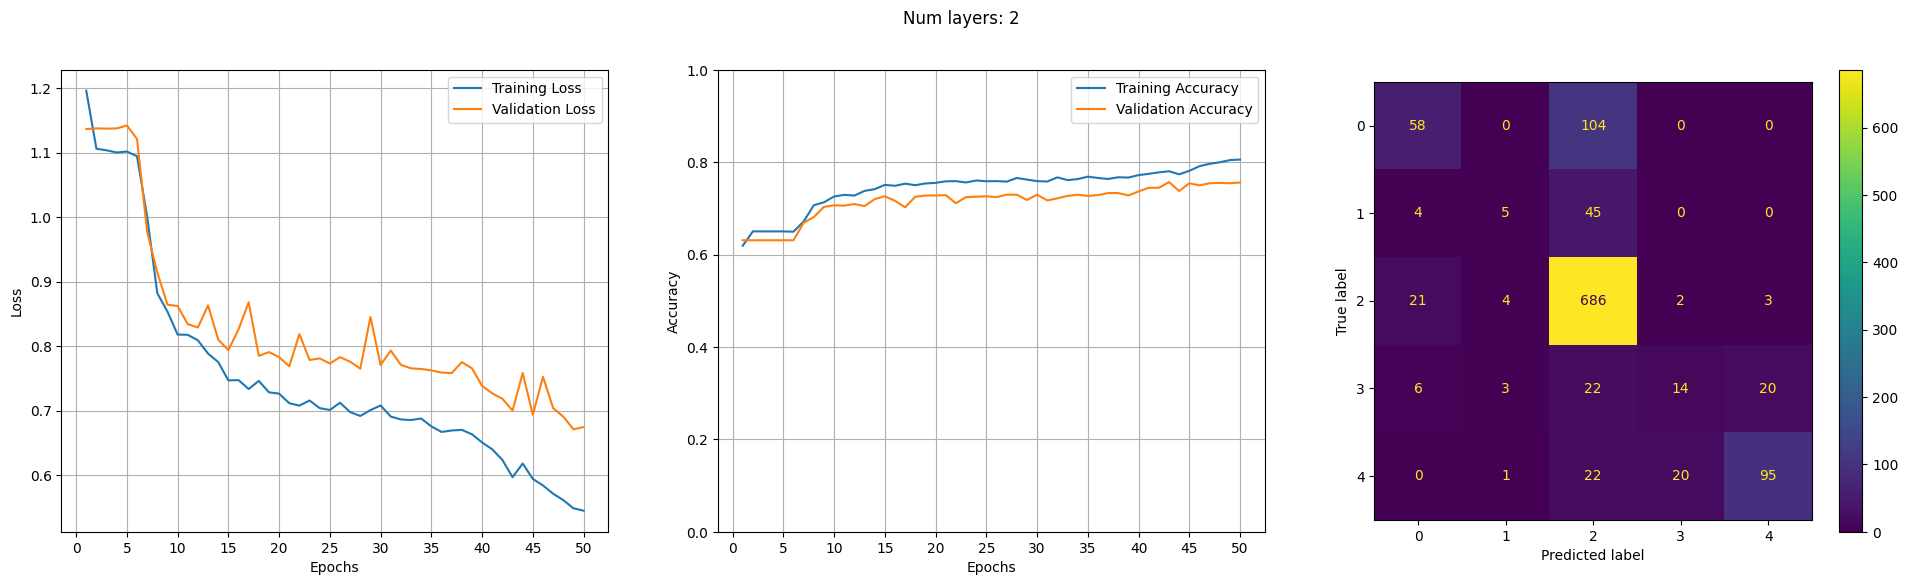

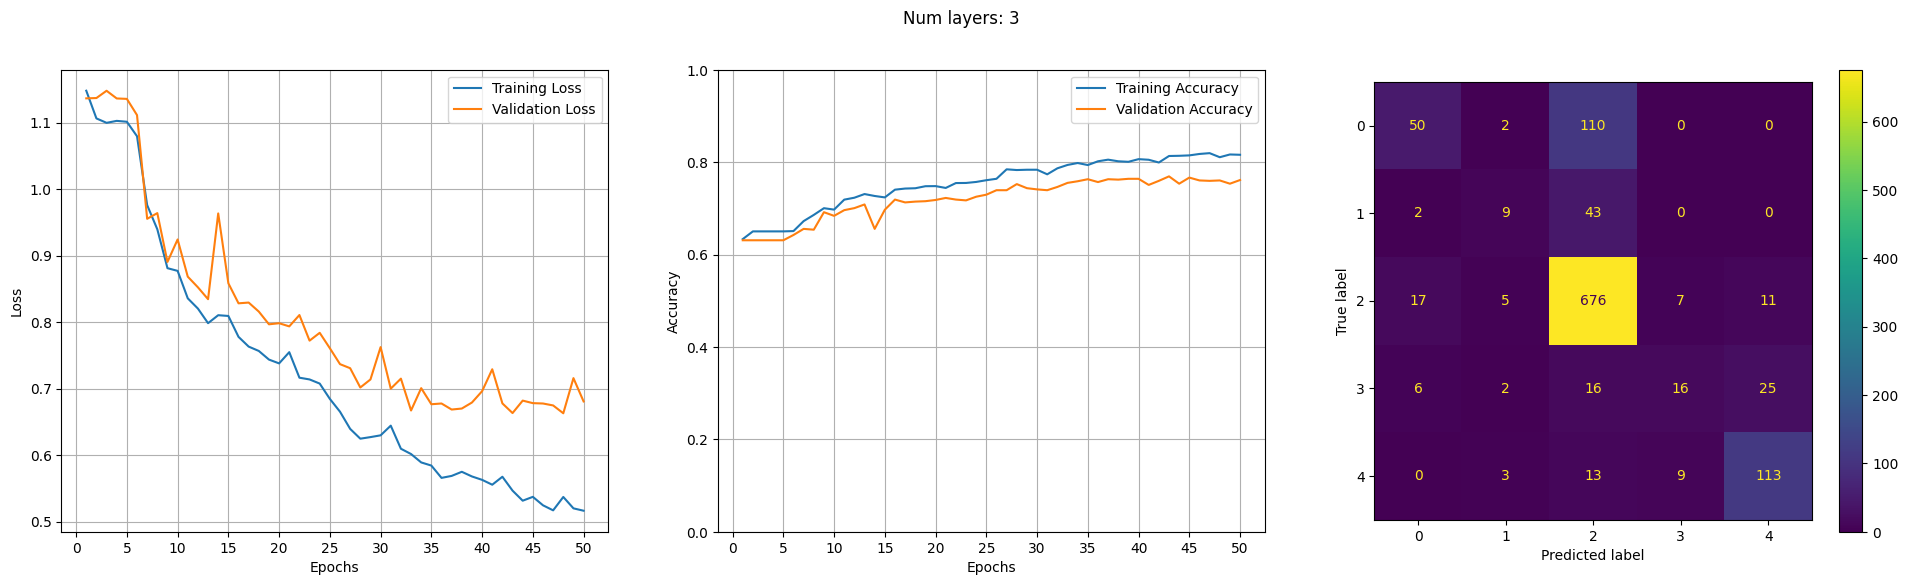

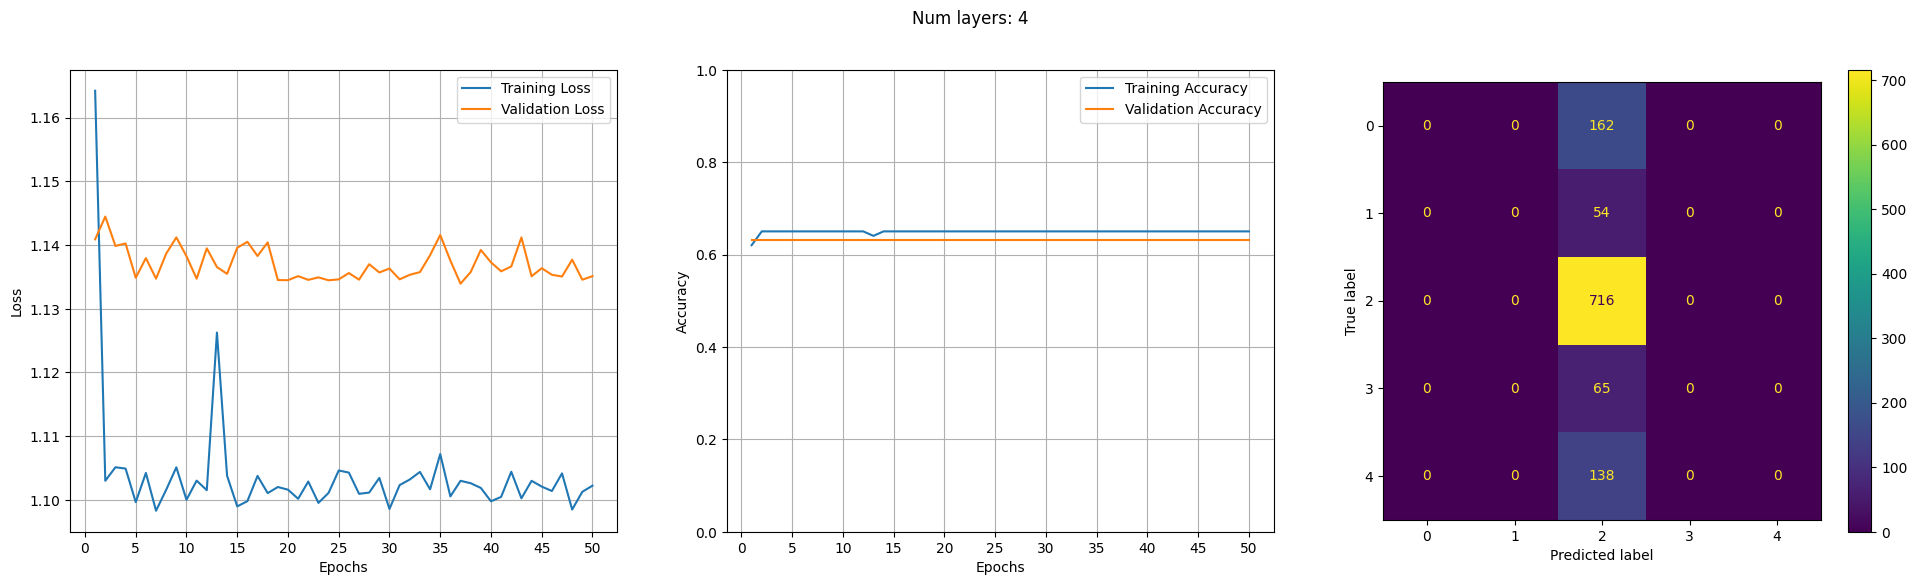

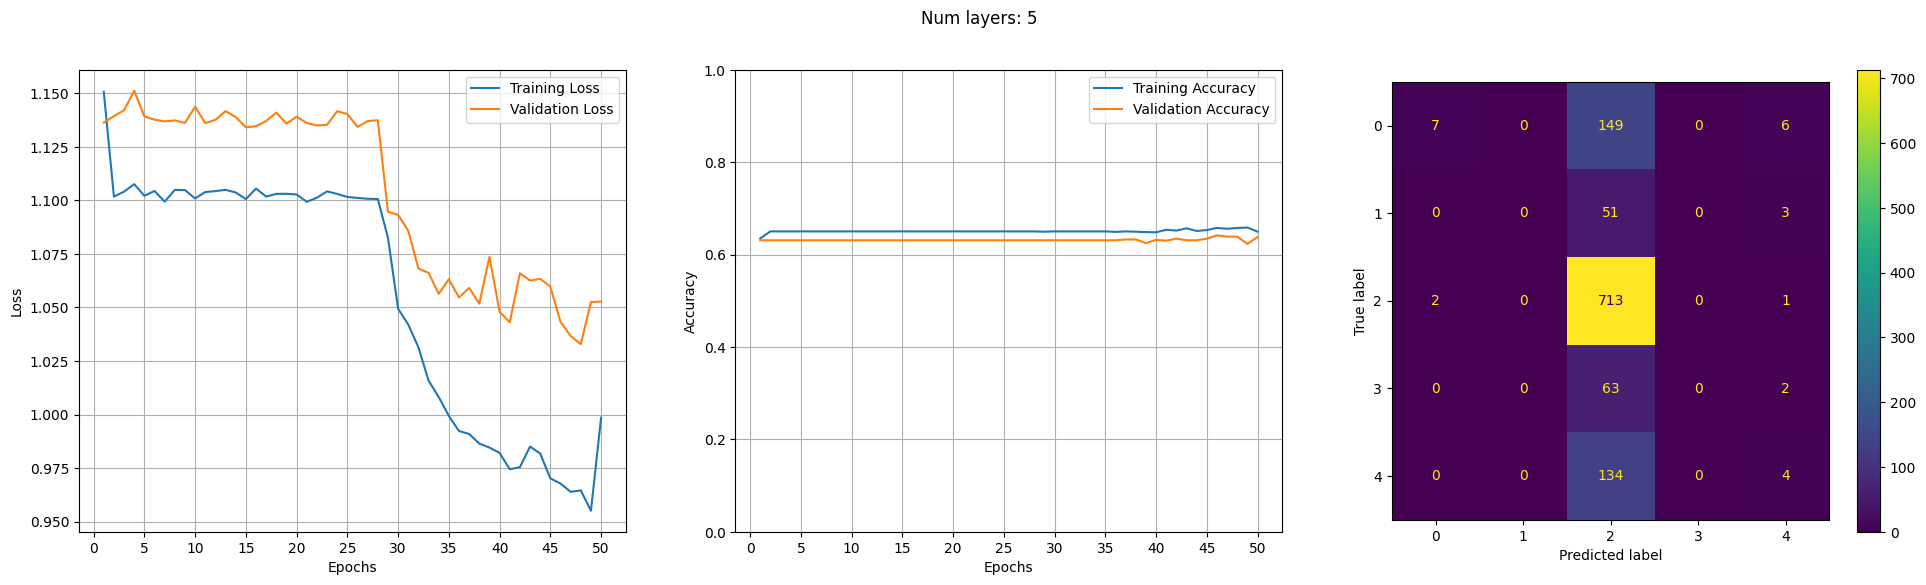

In [24]:
stacked_plots(results_multi_layer)

#### Findings

Increasing the number of layers beyond three does not improve performance, but instead leads to model collapse, where predictions become completely skewed towards the majority class. This is probably due to the limited size of the dataset relative to the complexity of the model.


### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

In [25]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Class weights in the loss

In [26]:
### START YOUR CODE
labels = np.array(train['lang'])
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
### END YOUR CODE

In [27]:
### START YOUR CODE
results_class_imbalance = {}

batch_size = 128
hidden_dim = 64
n_layers = 2

train_loader = DataLoader(Xy_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Xy_test, batch_size=batch_size, shuffle=False)

model = RNN(input_dim, hidden_dim, output_dim, n_layer).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, test_loader, optimizer, criterion, n_epochs)
results_class_imbalance['Class weights'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues
### END YOUR CODE

Training Progress: 100%|██████████| 1800/1800 [01:22<00:00, 21.73it/s, Epoch=50/50, Train Loss=1.1789, Val Loss=1.1546, Train Acc=0.5723, Val Acc=0.6308]


### Oversampling by minority resampling

In [28]:
X = train['name'].values.reshape(-1, 1)
y = train['lang'].values

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

train_balanced = pd.DataFrame({'name': X_res.flatten(), 'lang': y_res})
Xy_train_balanced = NameDataset(train_balanced, char_index, language_to_index, maxlen)

In [30]:
### START YOUR CODE
batch_size = 128
hidden_dim = 64
n_layers = 2

train_loader = DataLoader(Xy_train_balanced, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Xy_test, batch_size=batch_size, shuffle=False)

model = RNN(input_dim, hidden_dim, output_dim, n_layer).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, test_loader, optimizer, criterion, n_epochs)
results_class_imbalance['Minority resampling'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues
### END YOUR CODE

Training Progress: 100%|██████████| 5800/5800 [04:18<00:00, 22.45it/s, Epoch=50/50, Train Loss=0.2179, Val Loss=1.6273, Train Acc=0.9230, Val Acc=0.6696]


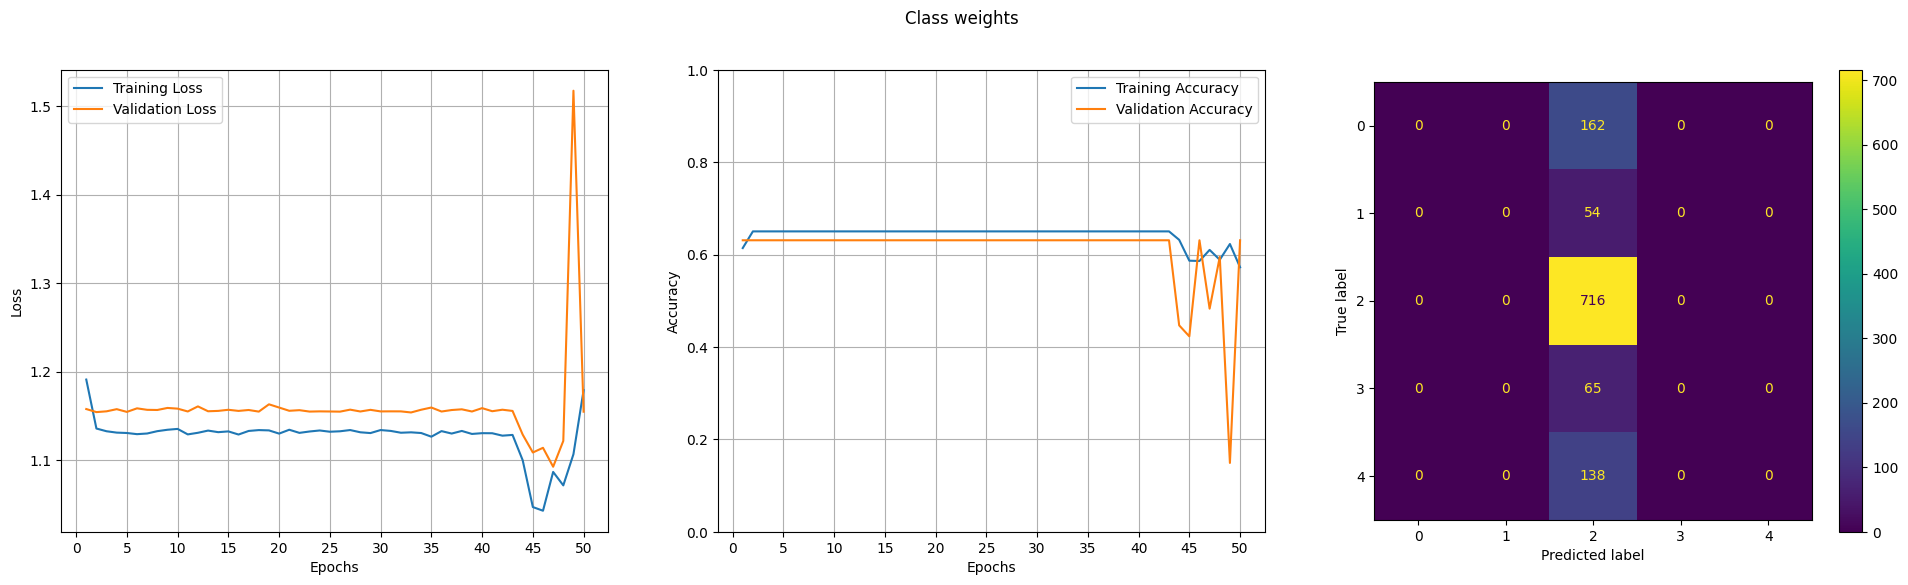

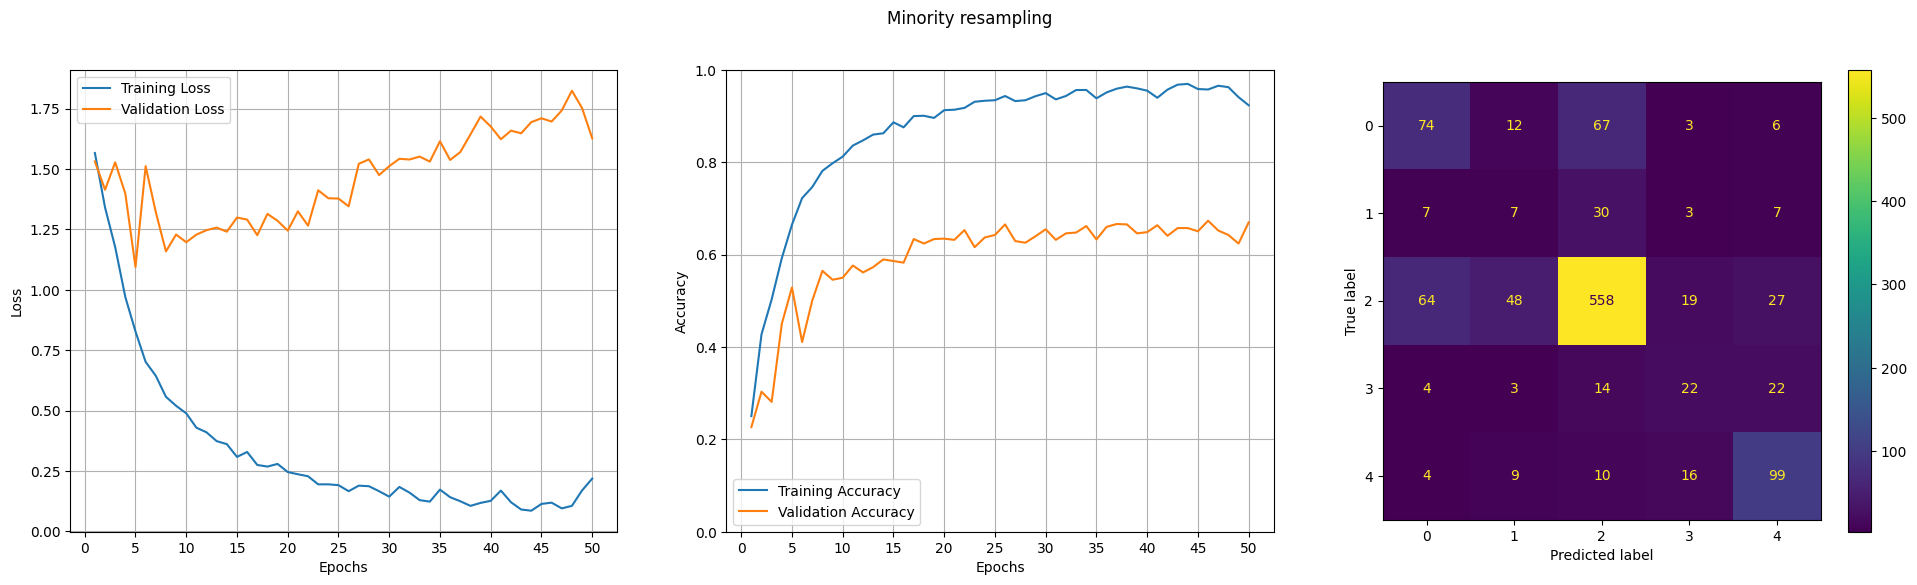

In [31]:
stacked_plots(results_class_imbalance)

#### Findings
Introducing class weights into the loss function does not improve model learning. Training stagnates early and the final epoch shows unstable behaviour, likely caused by large gradients of over-weighted minority classes. This suggests that the dataset is too small to support such aggressive rebalancing.

Minority resampling reduces the dominance of the majority class in the predictions, but causes severe overfitting. The model achieves near perfect accuracy on the training set, but fails to generalise, as evidenced by a scattered confusion matrix and poor validation performance. This suggests that the model memorises duplicate samples rather than learning generalisable patterns.